In [1]:
import os
filename = 'AllPublicnew.sdf'
filepath = f'/content/{filename}'

download_url = f'https://zenodo.org/records/3540701/files/{filename}'

if not os.path.exists(filepath):
    !wget {download_url} -O {filepath}
else:
    print("File already exists:", filepath)


In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
!pip install jaqpotpy
!pip install rdkit


!pip install scikit-learn
!pip install PyTDC


In [212]:
from rdkit import Chem
from rdkit.Chem import AllChem
from pathlib import Path

import pandas as pd
import random
import numpy as np

seed = 42
np.random.seed(seed)
random.seed(seed)




working_dir = Path.cwd()
filename = 'AllPublicnew.sdf'

dataset_filepath = working_dir/filename




X, y = [], []
sdf_supplier = Chem.SDMolSupplier(str(dataset_filepath))

for mol in sdf_supplier:
    if mol is not None:
        smiles = mol.GetProp('SMILES')
        # smiles = Chem.MolToSmiles(mol)
        ready_biodegradability = int(mol.GetProp('ReadyBiodegradability'))

        X.append(smiles)
        y.append(ready_biodegradability)




zipped = list(zip(X, y))
random.shuffle(zipped)
list1, list2 = zip(*zipped)


X = pd.DataFrame(X, columns=['SMILES'])
y = pd.DataFrame(y, columns=['Y'])


# Shuffle data
Xy = pd.concat([X, y], axis=1).sample(frac=1, random_state=seed).reset_index(drop=True)
X = Xy[['SMILES']]
y = Xy[['Y']]



In [213]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


def class_balanced_random_split(X, y, seed=None, test_ratio_per_class=0.15):
    """
    Class-balanced dataset split into train and test partitions.

    Args:
        X (array-like): array-like of data input data points
        y (array-like): array-like of labels
        seed (int, optional): Random seed (Default: None)
        test_ratio_per_class (float, optional): Percentage of test samples per class (Default: 0.15)

    Returns:
        (tuple):
            * X_train (array-like): array-list of train data points
            * X_test (array-like): array-list of test data points
            * y_train (array-like): array-like list of train labels
            * y_test (array-like): array-like of test labels
    """


    if isinstance(y, list):
        idx2label = y
    elif isinstance(y, pd.DataFrame):
        idx2label = y.iloc[:, 0].tolist()
    elif isinstance(y, np.ndarray):
        idx2label = y
    else:
        raise TypeError(f"Unsupported type for y: {type(y)}")


    class_indices = {}
    for idx, label in enumerate(idx2label):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)


    train_indices = []
    test_indices = []
    for label, indices in class_indices.items():
        if len(indices) > 1:
            train_idx, test_idx = train_test_split(indices, test_size=test_ratio_per_class, random_state=seed)
        else:
            train_idx, test_idx = indices.copy(), []
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)


    if isinstance(X, list):
        X_train = [X[i] for i in train_indices]
        X_test = [X[i] for i in test_indices]
    elif isinstance(X, pd.DataFrame):
        X_train = X.iloc[train_indices]
        X_test = X.iloc[test_indices]
        X_train.reset_index(inplace=True, drop=True)
        X_test.reset_index(inplace=True, drop=True)
    elif isinstance(X, np.ndarray):
        X_train = X[train_indices]
        X_test = X[test_indices]
    else:
        raise TypeError(f"Unsupported type for X: {type(X)}")


    if isinstance(y, list):
        y_train = [y[i] for i in train_indices]
        y_test = [y[i] for i in test_indices]
    elif isinstance(y, pd.DataFrame):
        y_train = y.iloc[train_indices]
        y_test = y.iloc[test_indices]
        y_train.reset_index(inplace=True, drop=True)
        y_test.reset_index(inplace=True, drop=True)
    elif isinstance(y, np.ndarray):
        y_train = y[train_indices]
        y_test = y[test_indices]
    else:
        raise TypeError(f"Unsupported type for y: {type(y)}")


    return X_train, X_test, y_train, y_test


In [214]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler

n_all = len(y)
print(f"Whole Dataset ({100*(np.array(y)==1).sum()/n_all:.1f}% positive):")
print(f"- Positive Samples: {(np.array(y)==1).sum():,}")
print(f"- Negative Samples: {(np.array(y)==0).sum():,}")
print('\n')


# Create test split
X_train_val, X_test, y_train_val, y_test = class_balanced_random_split(X, y, seed=seed)

# Create train and validation splits
X_train, X_val, y_train, y_val = class_balanced_random_split(X_train_val, y_train_val, seed=seed)


n_train = len(y_train)
print(f"Train Split ({100*(np.array(y_train)==1).sum()/n_train:.1f}% positive):")
print(f"- Positive Train Samples: {(np.array(y_train)==1).sum():,}")
print(f"- Negative Train Samples: {(np.array(y_train)==0).sum():,}")
print('\n')



X_train_oversampled, y_train_oversampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)

n_train_oversampled = len(y_train_oversampled)
print(f"Train Split after Oversampling ({100*(np.array(y_train_oversampled)==1).sum()/n_train_oversampled:.1f}% positive):")
print(f"- Positive Train Samples: {(np.array(y_train_oversampled)==1).sum():,}")
print(f"- Negative Train Samples: {(np.array(y_train_oversampled)==0).sum():,}")
print('\n')


n_val = len(y_val)
print(f"Validation Split ({100*(np.array(y_val)==1).sum()/n_val:.1f}% positive):")
print(f"- Positive Validation Samples: {(np.array(y_val)==1).sum():,}")
print(f"- Negative Validation Samples: {(np.array(y_val)==0).sum():,}")
print('\n')

n_test = len(y_test)
print(f"Test Split ({100*(np.array(y_test)==1).sum()/n_test:.1f}% positive):")
print(f"- Positive Test Samples: {(np.array(y_test)==1).sum():,}")
print(f"- Negative Test Samples: {(np.array(y_test)==0).sum():,}")
print('\n')



Whole Dataset (35.5% positive):
- Positive Samples: 1,133
- Negative Samples: 2,059


Train Split (35.5% positive):
- Positive Train Samples: 818
- Negative Train Samples: 1,487


Train Split after Oversampling (50.0% positive):
- Positive Train Samples: 1,487
- Negative Train Samples: 1,487


Validation Split (35.5% positive):
- Positive Validation Samples: 145
- Negative Validation Samples: 263


Test Split (35.5% positive):
- Positive Test Samples: 170
- Negative Test Samples: 309




In [215]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



def sklearn_grid_search_cv_and_test(X,
                                    y,
                                    pipeline_functions_steps,
                                    param_grid,
                                    n_folds=5,
                                    verbose=0,
                                    scoring='f1',
                                    seed=None):
    
    
    X_train_val, X_test, y_train_val, y_test = class_balanced_random_split(X, y, seed=seed)
    



    pipeline_steps = [(module, module_function()) for module, module_function in pipeline_functions_steps]
    pipeline = Pipeline(pipeline_steps)

    

    grid_search = GridSearchCV(pipeline, param_grid, cv=n_folds, scoring=scoring, verbose=verbose)
    grid_search.fit(X_train_val, y_train_val)

    # Hyperparameter Tuning
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    if verbose >= 0.5:
        print("Best Parameters:", best_params)
        print(f"Best Validation Score ({scoring}): {best_score:.4f}")


    best_estimator = grid_search.best_estimator_


    scorer = metrics.get_scorer(scoring)
    scr = scorer(best_estimator, X_test, y_test)
    
    if verbose >= 0.5:
        print(f"{scoring}-score on test set: {scr:.4f}")
    
    
    
#     best_params_dict = {}

#     for param_name, param_value in best_params.items():
#         module, internal_param_name = param_name.split('__')

#         if module not in best_params_dict:
#             best_params_dict[module] = {}

#         best_params_dict[module][internal_param_name] = param_value
    
    
#     final_pipeline_steps = [(module, module_function(**best_params_dict.get(module, {})))
#                             for module, module_function in pipeline_function_steps]
        
        
    
#     final_pipeline = Pipeline(final_pipeline_steps)
#     final_pipeline.fit(X_train_val, y_train_val)
    
#     f1 = f1_scorer(pipeline, X_test, y_test)
#     print("F1-score on test set:", f1)
  
    return_dict = {
        'best_estimator': best_estimator,
        'best_params': best_params,
        'best_score': best_score
    }
    
    return return_dict





In [216]:
import copy
from imblearn.over_sampling import RandomOverSampler
import sklearn.metrics as metrics


def score_after_oversampling(X, y, best_classifier, scoring='f1', oversampling=True, seed):
    X_train, X_test, y_train, y_test = class_balanced_random_split(X, y, seed=seed)
    
    if oversampling:
        # Oversampling to balance classes
        print("Oversampling the Training set and then fit the optimal pipeline...\n")
        X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

    
    final_classifier = copy.deepcopy(best_classifier['best_estimator'])
    final_classifier.fit(X_train, y_train)


    scorer = metrics.get_scorer(scoring)
    scr = scorer(final_classifier, X_test, y_test)

    print(f"{scoring}-score on test set after applying oversampling the training set: {scr:.4f}")
    
    return final_classifier

# Scikit-learn Pipeline Tuning with GridSearchCV 

## Circular (Morgan) Fingerprints - Topological Fingerprint

In [204]:
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import TopologicalFingerprint


featurizer = TopologicalFingerprint()
jaq_dataset = SmilesDataset(smiles=X['SMILES'],
                            y=y['Y'].values,
                            featurizer=featurizer,
                            task='classification').create()


X_topological, y_topological = jaq_dataset.df[jaq_dataset.X].to_numpy(), jaq_dataset.df[jaq_dataset.y].to_numpy().ravel()


Creating descriptors: 100%|███████████████████████████████████████████████████████| 3192/3192 [00:04<00:00, 707.28it/s]


### Support Vector Machine (SVM)

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn
from sklearn import metrics
import numpy as np

from sklearn.feature_selection import VarianceThreshold



n_features = X_topological.shape[1]


pipeline_functions_steps = [
#     ('pca', PCA),
#     ('scaler', StandardScaler),
    ('vt', VarianceThreshold),
    ('classifier', SVC)
]




param_grid = {
#     'pca__random_state': [seed],
#     'pca__n_components': [0.75],
    'vt__threshold': [0, 5e-4, 1e-3, 5e-3, 1e-2],
    'classifier__C': [0.1, 1.0, 10, 100],
    'classifier__kernel': ['linear','rbf', 'sigmoid', 'poly'],
    'classifier__random_state': [seed],
}





best_svm_classifier = sklearn_grid_search_cv_and_test(X_topological, y_topological, pipeline_functions_steps, param_grid,
                                                      n_folds=5, verbose=0.5, scoring='f1', seed=seed)

# score_after_oversampling(X_topological, y_topological, best_svm_classifier, seed)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf', 'classifier__random_state': 42, 'vt__threshold': 0.001}
Best Validation Score (f1): 0.7568
f1-score on test set: 0.7178


Pipeline(steps=[('vt', VarianceThreshold(threshold=0.001)),
                ('classifier', SVC(C=10, random_state=42))])

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier



n_features = X_topological.shape[1]

pipeline_functions_steps = [
    ('classifier', RandomForestClassifier)
]


param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200, 300, 500],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__random_state': [seed],
}



best_rf_classifier = sklearn_grid_search_cv_and_test(X_topological, y_topological, pipeline_functions_steps, param_grid,
                                                     n_folds=5, verbose=0.5, scoring='f1', seed=seed)



score_after_oversampling(X_topological, y_topological, best_rf_classifier, seed)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'classifier__criterion': 'entropy', 'classifier__n_estimators': 300, 'classifier__random_state': 42}
Best Validation Score (f1): 0.7576
f1-score on test set: 0.7160
Oversampling the Training set and then fit the optimal pipeline...

f1-score on test set after applying oversampling the training set: 0.7393


Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=300,
                                        random_state=42))])

### K-Nearest Neighbors

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


n_features = X_topological.shape[1]


pipeline_functions_steps = [
#     ('scaler', StandardScaler),
    ('classifier', KNeighborsClassifier)
]


param_grid = {
    'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'classifier__weights': ['uniform', 'distance'],
}



best_knn_classifier = sklearn_grid_search_cv_and_test(X_topological, y_topological, pipeline_functions_steps, param_grid,
                                                      n_folds=5, verbose=0.5, scoring='f1', seed=seed)

score_after_oversampling(X_topological, y_topological, best_knn_classifier, seed)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}
Best Validation Score (f1): 0.7074
f1-score on test set: 0.6915
Oversampling the Training set and then fit the optimal pipeline...

f1-score on test set after applying oversampling the training set: 0.6915


Pipeline(steps=[('classifier', KNeighborsClassifier(n_neighbors=1))])

### Multilayer Perceptron (MLP)

In [16]:
from sklearn.neural_network import MLPClassifier


pipeline_functions_steps = [
    ('scaler', StandardScaler),
    ('classifier', MLPClassifier)
]


param_grid = {
    'classifier__hidden_layer_sizes': [[64], [128], [128, 64]],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__learning_rate_init': [5e-4, 1e-3, 5e-3],
    'classifier__max_iter': [500]
}


best_mlp_classifier = sklearn_grid_search_cv_and_test(X_topological, y_topological, pipeline_functions_steps, param_grid,
                                                      n_folds=5, verbose=0.5, scoring='f1', seed=seed)

score_after_oversampling(X_topological, y_topological, best_mlp_classifier, seed)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'classifier__hidden_layer_sizes': [128], 'classifier__learning_rate': 'constant', 'classifier__learning_rate_init': 0.005, 'classifier__max_iter': 500, 'classifier__solver': 'sgd'}
Best Validation Score (f1): 0.7400
f1-score on test set: 0.6994
Oversampling the Training set and then fit the optimal pipeline...

f1-score on test set after applying oversampling the training set: 0.6867


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=[128],
                               learning_rate_init=0.005, max_iter=500,
                               solver='sgd'))])

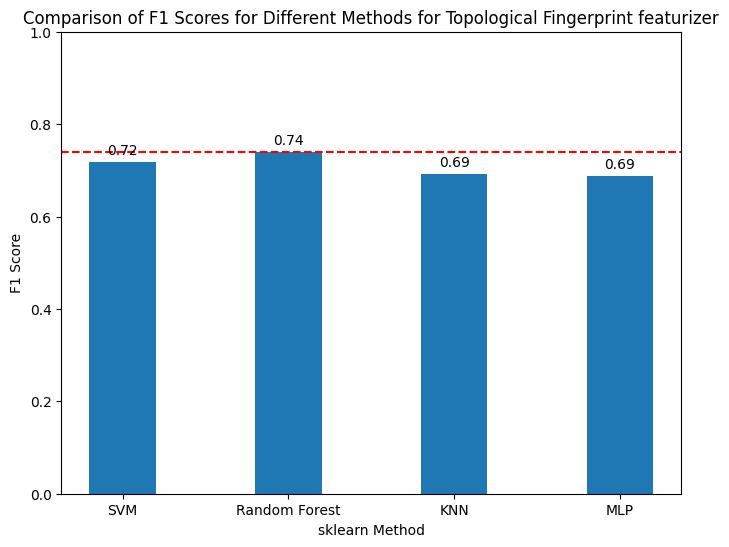

In [30]:
import matplotlib.pyplot as plt

methods = ['SVM', 'Random Forest', 'KNN', 'MLP']

f1_scores = [0.7178, 0.7393 ,0.6915 , 0.6867]

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, f1_scores, width=0.4)

plt.xlabel('sklearn Method')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Different Methods for Topological Fingerprint featurizer')
plt.ylim([0,1])

plt.axhline(max(f1_scores), color='red', linestyle='--')

for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom')



plt.show()


## MACCS Keys (Molecular ACCess System):

In [226]:
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import MACCSKeysFingerprint


featurizer = MACCSKeysFingerprint()
jaq_dataset = SmilesDataset(smiles=X['SMILES'],
                            y=y['Y'].values,
                            featurizer=featurizer,
                            task='classification').create()


X_MACCS, y_MACCS = jaq_dataset.df[jaq_dataset.X].to_numpy(), jaq_dataset.df[jaq_dataset.y].to_numpy().ravel()


Creating descriptors: 100%|███████████████████████████████████████████████████████| 3192/3192 [00:04<00:00, 747.44it/s]


### Support Vector Machine 

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import sklearn
from sklearn import metrics
import numpy as np

from sklearn.feature_selection import VarianceThreshold



n_features = X_MACCS.shape[1]


pipeline_functions_steps = [
#     ('pca', PCA),
#     ('scaler', StandardScaler),
    ('vt', VarianceThreshold),
    ('classifier', SVC)
]




param_grid = {
#     'pca__random_state': [seed],
#     'pca__n_components': [0.75],
    'vt__threshold': [0, 5e-4, 1e-3, 5e-3, 1e-2],
    'classifier__C': [0.1, 1.0, 10, 100],
    'classifier__kernel': ['linear','rbf', 'sigmoid', 'poly'],
    'classifier__random_state': [seed],
}





best_svm_classifier = sklearn_grid_search_cv_and_test(X_MACCS, y_MACCS, pipeline_functions_steps, param_grid,
                                                      n_folds=5, verbose=0.5, scoring='f1', seed=seed)

score_after_oversampling(X_MACCS, y_MACCS, best_svm_classifier, seed)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'classifier__C': 1.0, 'classifier__kernel': 'rbf', 'classifier__random_state': 42, 'vt__threshold': 0.001}
Best Validation Score (f1): 0.7797
f1-score on test set: 0.7692
Oversampling the Training set and then fit the optimal pipeline...

f1-score on test set after applying oversampling the training set: 0.7933


Pipeline(steps=[('vt', VarianceThreshold(threshold=0.001)),
                ('classifier', SVC(random_state=42))])

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier



n_features = X_MACCS.shape[1]

pipeline_functions_steps = [
    ('classifier', RandomForestClassifier)
]


param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200, 300, 500],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__random_state': [seed],
}



best_rf_classifier = sklearn_grid_search_cv_and_test(X_MACCS, y_MACCS, pipeline_functions_steps, param_grid,
                                                     n_folds=5, verbose=0.5, scoring='f1', seed=seed)



score_after_oversampling(X_MACCS, y_MACCS, best_rf_classifier, seed)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'classifier__criterion': 'entropy', 'classifier__n_estimators': 500, 'classifier__random_state': 42}
Best Validation Score (f1): 0.7867
f1-score on test set: 0.7882
Oversampling the Training set and then fit the optimal pipeline...

f1-score on test set after applying oversampling the training set: 0.7771


Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=500,
                                        random_state=42))])

### K-Nearest Neighbors

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


n_features = X_MACCS.shape[1]


pipeline_functions_steps = [
#     ('scaler', StandardScaler),
    ('classifier', KNeighborsClassifier)
]


param_grid = {
    'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'classifier__weights': ['uniform', 'distance'],
}



best_knn_classifier = sklearn_grid_search_cv_and_test(X_MACCS, y_MACCS, pipeline_functions_steps, param_grid,
                                                      n_folds=5, verbose=0.5, scoring='f1', seed=seed)

score_after_oversampling(X_MACCS, y_MACCS, best_knn_classifier, seed)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'classifier__n_neighbors': 13, 'classifier__weights': 'distance'}
Best Validation Score (f1): 0.7657
f1-score on test set: 0.7541
Oversampling the Training set and then fit the optimal pipeline...

f1-score on test set after applying oversampling the training set: 0.7463


Pipeline(steps=[('classifier',
                 KNeighborsClassifier(n_neighbors=13, weights='distance'))])

### Multilayer Perceptron

In [21]:
from sklearn.neural_network import MLPClassifier


pipeline_functions_steps = [
    ('scaler', StandardScaler),
    ('classifier', MLPClassifier)
]


param_grid = {
    'classifier__hidden_layer_sizes': [[64], [128], [128, 64]],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__learning_rate_init': [5e-4, 1e-3, 5e-3],
    'classifier__max_iter': [500]
}


best_mlp_classifier = sklearn_grid_search_cv_and_test(X_MACCS, y_MACCS, pipeline_functions_steps, param_grid,
                                                      n_folds=5, verbose=0.5, scoring='f1', seed=seed)

score_after_oversampling(X_MACCS, y_MACCS, best_mlp_classifier, seed)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Best Parameters: {'classifier__hidden_layer_sizes': [128], 'classifier__learning_rate': 'constant', 'classifier__learning_rate_init': 0.0005, 'classifier__max_iter': 500, 'classifier__solver': 'sgd'}
Best Validation Score (f1): 0.7852
f1-score on test set: 0.7560
Oversampling the Training set and then fit the optimal pipeline...



C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


f1-score on test set after applying oversampling the training set: 0.7556


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=[128],
                               learning_rate_init=0.0005, max_iter=500,
                               solver='sgd'))])

In [236]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

svm_pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.001)),
    ('classifier', SVC(C=1.0, kernel='rbf', gamma=0.1, random_state=seed, probability=True)), 
])

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=[128],
                                 learning_rate_init=0.0005,
                                 max_iter=500,
                                 solver='sgd',
                                 random_state=seed))
])

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=13, weights='distance'))
])

rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=seed))
])

estimators = [('svm', svm_pipeline),
              ('mlp', mlp_pipeline),
              ('knn', knn_pipeline),
              ('rf', rf_pipeline)
             ]




# Define the Voting Classifier
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft'  
)




def eyo(X, y, best_classifier, seed):
    X_train, X_test, y_train, y_test = class_balanced_random_split(X, y, seed=seed)

    # Oversampling to balance classes
    print("Oversampling the Training set and then fit the optimal pipeline...\n")
    X_train_oversampled, y_train_oversampled = RandomOverSampler().fit_resample(X_train, y_train)

    
    final_classifier = copy.deepcopy(best_classifier)
    final_classifier.fit(X_train_oversampled, y_train_oversampled)


    scoring = 'f1'
    f1_scorer = metrics.get_scorer(scoring)
    f1 = f1_scorer(final_classifier, X_test, y_test)

    print(f"{scoring}-score on test set after applying oversampling the training set: {f1:.4f}")
    
    return final_classifier


eyo(X_MACCS, y_MACCS, svm_pipeline, seed)



Oversampling the Training set and then fit the optimal pipeline...

f1-score on test set after applying oversampling the training set: 0.7781


Pipeline(steps=[('vt', VarianceThreshold(threshold=0.001)),
                ('classifier',
                 SVC(gamma=0.1, probability=True, random_state=42))])

In [239]:
from jaqpotpy.models.evaluator import Evaluator
from jaqpotpy.models import MolecularSKLearn
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import TopologicalFingerprint, MACCSKeysFingerprint
from jaqpotpy import Jaqpot
from jaqpotpy.doa.doa import Leverage, SmilesLeverage, MeanVar

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import RandomOverSampler


pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.001)),
    ('classifier', SVC(C=1.0, kernel='rbf', gamma=0.1, random_state=seed, probability=True)), 
])

# Declar Domain of Applicability
doa = Leverage()


# Declare the Featurizer
featurizer = MACCSKeysFingerprint()

# Initialize Evaluator
evaluator = Evaluator()

# Declare and Register Evaluator's metrics
eval_metrics = {
    'accuracy': metrics.accuracy_score,
    'balanced_accuracy': metrics.balanced_accuracy_score,
    'f1': metrics.f1_score,
    'precision': metrics.precision_score,
    'recall': metrics.recall_score,
    'roc_auc': metrics.roc_auc_score,
    'mcc': metrics.matthews_corrcoef
}

for metric_name, metric_func in eval_metrics.items():
    evaluator.register_scoring_function(metric_name, metric_func)

    
    
X_train, X_test, y_train, y_test = class_balanced_random_split(X, y, seed=seed, test_ratio_per_class=0.15)



#  --- NOTE: Remove lines after bug fix of dataframe indices ---
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)




# Oversample minority class to tackle class imbalance
X_train, y_train = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)


# Train Smiles Dataset
jaq_train = SmilesDataset(smiles=X_train['SMILES'],
                          y=y_train['Y'].values,
                          featurizer=featurizer,
                          task='classification').create()

# Validation Smiles Dataset
jaq_test = SmilesDataset(smiles=X_test['SMILES'],
                        y=y_test['Y'].values,
                        featurizer=featurizer,
                        task='classification').create()

# Set val jaqpot dataset as Evaluator's dataset
evaluator.dataset = jaq_test


# Train the model
model = MolecularSKLearn(jaq_train, doa=doa, model=voting_clf, eval=evaluator)
trained_model = model.fit()



Creating descriptors: 100%|█████████████████████████████████████████████████████████| 479/479 [00:00<00:00, 874.89it/s]
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.

NotImplementedError: flatten_transform==True is not implemented yet. You may raise an issue at https://github.com/onnx/sklearn-onnx/issues.

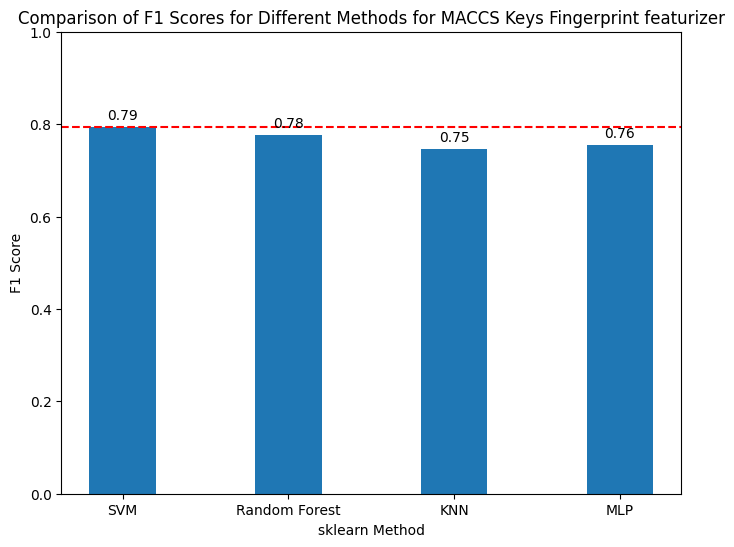

In [29]:
import matplotlib.pyplot as plt

methods = ['SVM', 'Random Forest', 'KNN', 'MLP']

f1_scores = [0.7933, 0.7771 ,0.7463 , 0.7556]

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, f1_scores, width=0.4)

plt.xlabel('sklearn Method')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Different Methods for MACCS Keys Fingerprint featurizer')
plt.ylim([0,1])

plt.axhline(max(f1_scores), color='red', linestyle='--')
# plt.text(0.5, max(f1_scores)+0.02, f'{highest_score:.2f}', color='red', ha='center')


for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom')


plt.show()


# AutoML

## Circular (Morgan) Fingerprints - Topological Fingerprint

In [43]:
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import TopologicalFingerprint
from tpot import TPOTClassifier


featurizer = TopologicalFingerprint()
jaq_dataset_topological = SmilesDataset(smiles=X['SMILES'],
                                y=y['Y'].values,
                                featurizer=featurizer,
                                task='classification').create()

# Smiles Dataset to NumPy
X_topological = jaq_dataset_topological.df[jaq_dataset_topological.X].to_numpy()
y_topological = jaq_dataset_topological.df[jaq_dataset_topological.y].to_numpy().ravel()

# Split to Train/Test
X_train, X_test, y_train, y_test = class_balanced_random_split(X_topological, y_topological, seed=seed)

# Initialize TPOTClassifier instance
tpot_topological = TPOTClassifier(generations=5, population_size=50, scoring='f1', cv=5,
                                      verbosity=2, random_state=seed)

# Fit TPOTClassifier to train data
tpot_topological.fit(X_train, y_train)

# Fit TPOTClassifier to train data
f1_tpot_topological = tpot_topological.score(X_test, y_test)

print(f"f1-score on test set: {f1_tpot_topological:.4f}")

Creating descriptors: 100%|███████████████████████████████████████████████████████| 3192/3192 [00:03<00:00, 832.18it/s]


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7444651208454076

Generation 2 - Current best internal CV score: 0.7573016440549214

Generation 3 - Current best internal CV score: 0.7573016440549214

Generation 4 - Current best internal CV score: 0.7592466804125024

Generation 5 - Current best internal CV score: 0.7592466804125024

Best pipeline: LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l2)
f1-score on test set: 0.7215


## MACCS Keys (Molecular ACCess System):

In [38]:
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import MACCSKeysFingerprint
from tpot import TPOTClassifier


featurizer = MACCSKeysFingerprint()
jaq_dataset_MACCS = SmilesDataset(smiles=X['SMILES'],
                            y=y['Y'].values,
                            featurizer=featurizer,
                            task='classification').create()

# Smiles Dataset to NumPy
X_MACCS = jaq_dataset_MACCS.df[jaq_dataset_MACCS.X].to_numpy()
y_MACCS = jaq_dataset_MACCS.df[jaq_dataset_MACCS.y].to_numpy().ravel()

# Split to Train/Test
X_train, X_test, y_train, y_test = class_balanced_random_split(X_MACCS, y_MACCS, seed=seed)

# Initialize TPOTClassifier instance
tpot_MACCS = TPOTClassifier(generations=5, population_size=50, scoring='f1', cv=5,
                                    verbosity=2, random_state=seed)

# Fit TPOTClassifier to train data
tpot_MACCS.fit(X_train, y_train)

# F1-score on test set
f1_tpot_MACCS = tpot_MACCS.score(X_test, y_test)

print(f"f1-score on test set: {f1_tpot_MACCS:.4f}")


Creating descriptors: 100%|███████████████████████████████████████████████████████| 3192/3192 [00:03<00:00, 801.51it/s]


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7793569326950849

Generation 2 - Current best internal CV score: 0.7835409600358042

Generation 3 - Current best internal CV score: 0.7835409600358042

Generation 4 - Current best internal CV score: 0.7835409600358042

Generation 5 - Current best internal CV score: 0.7835409600358042

Best pipeline: MLPClassifier(input_matrix, alpha=0.001, learning_rate_init=0.001)
f1-score on test set: 0.7742


In [42]:
from sklearn.neural_network import MLPClassifier


pipeline = Pipeline([
    ('classifier', MLPClassifier(alpha=0.001, learning_rate_init=0.001, random_state=seed))
])

# MLPClassifier()





# Compare Scikit-learn and AutoML

## Circular (Morgan) Fingerprints - Topological Fingerprint


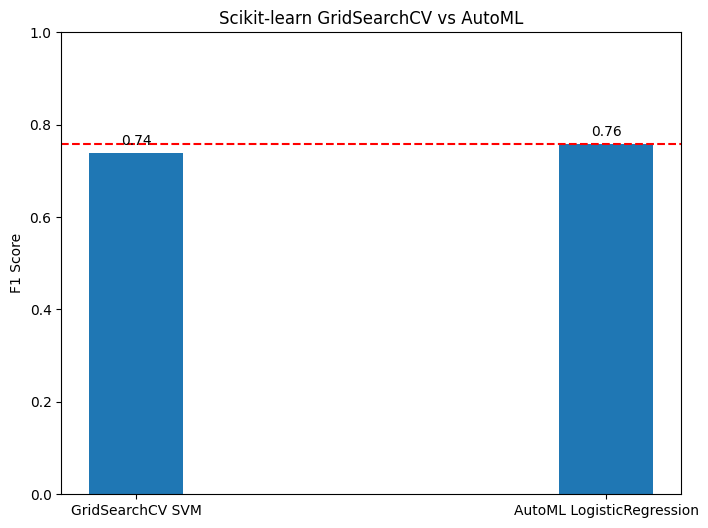

In [41]:
import matplotlib.pyplot as plt

methods = ['GridSearchCV SVM', 'AutoML LogisticRegression']


f1_scores = [0.7393 ,0.7592]

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, f1_scores, width=0.2)

# plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.title('Scikit-learn GridSearchCV vs AutoML')
plt.ylim([0,1])

plt.axhline(max(f1_scores), color='red', linestyle='--')

for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom')


plt.show()


## MACCS Keys (Molecular ACCess System):

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


methods = ['GridSearchCV SVM', 'AutoML LogisticRegression']

f1_scores = [0.7393 ,0.7592]

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, f1_scores, width=0.4)

# plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.title('Scikit-learn GridSearchCV vs AutoML')
plt.ylim([0,1])

plt.axhline(max(f1_scores), color='red', linestyle='--')

for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom')


plt.show()



In [ ]:
pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.001)),
    ('classifier', SVC(C=1.0, kernel='rbf', random_state=seed)), 
])




class_balanced_random_split(X_, y, seed=None, test_ratio_per_class=0.15)


# Metrics on best models

In [6]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(tp, fp, tn, fn):
    confusion_matrix = [[tn, fp], [fn, tp]]
    confusion_matrix_labels = [['TN', 'FP'], ['FN', 'TP']]

    # Plotting the confusion matrix
    plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])

    # Annotate each cell with respective counts
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f'{confusion_matrix_labels[i][j]}: {confusion_matrix[i][j]}', horizontalalignment='center', verticalalignment='center', color='black')

    plt.show()
    


Creating descriptors: 100%|███████████████████████████████████████████████████████| 3192/3192 [00:03<00:00, 877.78it/s]


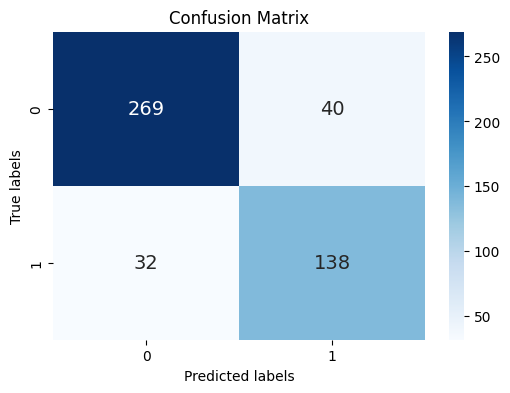

- Accuracy: 0.8497
- Balanced Accuracy: 0.8412
- Precision: 0.7753
- Recall: 0.8118
- F1 Score: 0.7931
- Matthews correlation coefficient (MCC): 0.6756


In [111]:
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import MACCSKeysFingerprint
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn import metrics
import seaborn as sns

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef




featurizer = MACCSKeysFingerprint()
jaq_dataset_MACCS = SmilesDataset(smiles=X['SMILES'],
                            y=y['Y'].values,
                            featurizer=featurizer,
                            task='classification').create()

# Smiles Dataset to NumPy
X_MACCS = jaq_dataset_MACCS.df[jaq_dataset_MACCS.X].to_numpy()
y_MACCS = jaq_dataset_MACCS.df[jaq_dataset_MACCS.y].to_numpy().ravel()
# Split to Train/Test
X_train, X_test, y_train, y_test = class_balanced_random_split(X_MACCS, y_MACCS, seed=seed)



pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.001)),
    ('classifier', SVC(C=1.0, kernel='rbf', gamma=0.1, random_state=seed)), 
])


X_train, y_train = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
pipeline.fit(X_train, y_train)



y_pred = pipeline.predict(X_test)



# Create confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()




# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f'- Accuracy: {accuracy:.4f}')
print(f'- Balanced Accuracy: {balanced_accuracy:.4f}')
print(f'- Precision: {precision:.4f}')
print(f'- Recall: {recall:.4f}')
print(f'- F1 Score: {f1:.4f}')
print(f'- Matthews correlation coefficient (MCC): {mcc:.4f}')




# Jaqpot

In [217]:
from jaqpotpy.models.evaluator import Evaluator
from jaqpotpy.models import MolecularSKLearn
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import TopologicalFingerprint, MACCSKeysFingerprint
from jaqpotpy import Jaqpot
from jaqpotpy.doa.doa import Leverage, SmilesLeverage, MeanVar
# from tdc.benchmark_group import admet_group
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline

import numpy as np



pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0.001)),
    ('classifier', SVC(C=1.0, kernel='rbf', gamma=0.1, random_state=seed, probability=True)), 
])



# doa = None
doa = Leverage()
# doa = SmilesLeverage()
# doa = MeanVar()


# XGBClassifier(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, verbosity=0)

# from sklearn.ensemble import GradientBoostingClassifier


# Declare the Featurizer
featurizer = MACCSKeysFingerprint()

# Initialize Evaluator
evaluator = Evaluator()

# Declare and Register Evaluator's metrics
eval_metrics = {
    'accuracy': metrics.accuracy_score,
    'balanced_accuracy': metrics.balanced_accuracy_score,
    'f1': metrics.f1_score,
    'precision': metrics.precision_score,
    'recall': metrics.recall_score,
    'roc_auc': metrics.roc_auc_score,
    'mcc': metrics.matthews_corrcoef
}

for metric_name, metric_func in eval_metrics.items():
    evaluator.register_scoring_function(metric_name, metric_func)

    
    
X_train, X_test, y_train, y_test = class_balanced_random_split(X, y, seed=seed, test_ratio_per_class=0.15)



#  --- NOTE: Remove lines after bug fix of dataframe indices ---
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)




# Oversample minority class to tackle class imbalance
X_train, y_train = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)


# Train Smiles Dataset
jaq_train = SmilesDataset(smiles=X_train['SMILES'],
                          y=y_train['Y'].values,
                          featurizer=featurizer,
                          task='classification').create()

# Validation Smiles Dataset
jaq_test = SmilesDataset(smiles=X_test['SMILES'],
                        y=y_test['Y'].values,
                        featurizer=featurizer,
                        task='classification').create()

# Set val jaqpot dataset as Evaluator's dataset
evaluator.dataset = jaq_test


# Train the model
model = MolecularSKLearn(jaq_train, doa=doa, model=pipeline, eval=evaluator)
trained_model = model.fit()



Creating descriptors: 100%|█████████████████████████████████████████████████████████| 479/479 [00:00<00:00, 847.35it/s]
C:\Users\pitfl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8496868475991649
balanced_accuracy: 0.8411574338473253
f1: 0.793103448275862
precision: 0.7752808988764045
recall: 0.8117647058823529
roc_auc: 0.8411574338473253
mcc: 0.6756087819499769


In [194]:
trained_model.doa.IN

[True]

In [197]:
print(trained_model.doa.IN)

octocrylene = "CCCCC(CC)COC(=O)C(=C(C1=CC=CC=C1)C2=CC=CC=C2)C#N"

trained_model([octocrylene])
trained_model.prediction

print(trained_model.doa.IN)

# trained_model.doa.predict([octocrylene])


[True, True]


Creating descriptors: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.74it/s]


[True]


In [218]:
from jaqpotpy import Jaqpot


jaqpot = Jaqpot()
# api_key = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJ3Ujh3X1lGOWpKWFRWQ2x2VHF1RkswZkctQXROQUJsb3FBd0N4MmlTTWQ4In0.eyJleHAiOjE3MDgxMjM1NzEsImlhdCI6MTcwNzk1MDc3MSwiYXV0aF90aW1lIjoxNzA3OTUwNzI4LCJqdGkiOiJhMmMyYWU2MS1iNTQ4LTRjN2UtOTY4Zi0yM2NiY2FjOWIwZGIiLCJpc3MiOiJodHRwczovL2xvZ2luLmphcXBvdC5vcmcvYXV0aC9yZWFsbXMvamFxcG90IiwiYXVkIjpbImJyb2tlciIsImFjY291bnQiXSwic3ViIjoiMzYxODhiNWYtYTk2MS00YTAwLWJjYTAtM2Y0ZTNkMDY4YTAxIiwidHlwIjoiQmVhcmVyIiwiYXpwIjoiamFxcG90LXVpLWNvZGUiLCJub25jZSI6IjIzZTczNzhiMjBmZmM1ODg0YmIyNDAxMmRmZDY4ZWJlMzA2UHh6WmNQIiwic2Vzc2lvbl9zdGF0ZSI6Ijg0ZjI2YmFlLTZiZjUtNDc0Yi1hMGRjLTYyN2IxZjdmNDk1YiIsImFjciI6IjAiLCJhbGxvd2VkLW9yaWdpbnMiOlsiJyonIiwiKiJdLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJkZWZhdWx0LXJvbGVzLWphcXBvdCIsInVtYV9hdXRob3JpemF0aW9uIl19LCJyZXNvdXJjZV9hY2Nlc3MiOnsiYnJva2VyIjp7InJvbGVzIjpbInJlYWQtdG9rZW4iXX0sImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIGphcXBvdC1hY2NvdW50cyBlbWFpbCBwcm9maWxlIHdyaXRlIHJlYWQiLCJzaWQiOiI4NGYyNmJhZS02YmY1LTQ3NGItYTBkYy02MjdiMWY3ZjQ5NWIiLCJlbWFpbF92ZXJpZmllZCI6ZmFsc2UsIm5hbWUiOiJHaWFubmlzIFBpdG9za2FzIiwicHJlZmVycmVkX3VzZXJuYW1lIjoianBpdG9za2FzQGdtYWlsLmNvbSIsImdpdmVuX25hbWUiOiJHaWFubmlzIiwiZmFtaWx5X25hbWUiOiJQaXRvc2thcyIsImVtYWlsIjoianBpdG9za2FzQGdtYWlsLmNvbSJ9.d2wwVdC-hik-KVo8RmaOBdHN9mKFFISb5IqTroElXEk-8rTNDCv4dLUgxdCp2ytowyYjdJANNIC3lONRYRukh4ISGSjAPo4tIsLGZD0aoFnPn_I5cZTH3hv7YIlBZGwY1bfgNfDWbsIiqK3xrhQ0Y3tmipbhcSWA0G2vIBf6EdDAGNp_U_AJfRhN6yf_TgDY2Px1b24dX44ZvSRupEXJt-dIObWCx8rFyzQp3eY7B7Lhhsz5RPtoNwqElON5mdNv5UkQaA23khyHSJPmAl28Q1BwlA0j3gHlNb7u_9aInNGPAT6PSekzmXkU9nwJ-kOakDewDlPOys-iHjYCZAyp6A"
api_key = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJ3Ujh3X1lGOWpKWFRWQ2x2VHF1RkswZkctQXROQUJsb3FBd0N4MmlTTWQ4In0.eyJleHAiOjE3MDg0ODA2OTgsImlhdCI6MTcwODMwNzg5OCwiYXV0aF90aW1lIjoxNzA4MzA3ODk3LCJqdGkiOiJiZDJjYzAwYi05YTIwLTQwMWYtYWE1NS03Yzg3NmQxZTAxN2UiLCJpc3MiOiJodHRwczovL2xvZ2luLmphcXBvdC5vcmcvYXV0aC9yZWFsbXMvamFxcG90IiwiYXVkIjpbImJyb2tlciIsImFjY291bnQiXSwic3ViIjoiMzYxODhiNWYtYTk2MS00YTAwLWJjYTAtM2Y0ZTNkMDY4YTAxIiwidHlwIjoiQmVhcmVyIiwiYXpwIjoiamFxcG90LXVpLWNvZGUiLCJub25jZSI6IjM1OWYyMmZhMjI1ZDdjMzAyYWI0ZDc2MGJlOTQyMDZmYjUyb1Z6b3ZxIiwic2Vzc2lvbl9zdGF0ZSI6IjVmMTUyZjc4LTJkMWUtNDdkMi04MTA0LTU0YTg4ZTdjMzhmNyIsImFjciI6IjEiLCJhbGxvd2VkLW9yaWdpbnMiOlsiJyonIiwiKiJdLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJkZWZhdWx0LXJvbGVzLWphcXBvdCIsInVtYV9hdXRob3JpemF0aW9uIl19LCJyZXNvdXJjZV9hY2Nlc3MiOnsiYnJva2VyIjp7InJvbGVzIjpbInJlYWQtdG9rZW4iXX0sImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIGphcXBvdC1hY2NvdW50cyBlbWFpbCBwcm9maWxlIHdyaXRlIHJlYWQiLCJzaWQiOiI1ZjE1MmY3OC0yZDFlLTQ3ZDItODEwNC01NGE4OGU3YzM4ZjciLCJlbWFpbF92ZXJpZmllZCI6ZmFsc2UsIm5hbWUiOiJHaWFubmlzIFBpdG9za2FzIiwicHJlZmVycmVkX3VzZXJuYW1lIjoianBpdG9za2FzQGdtYWlsLmNvbSIsImdpdmVuX25hbWUiOiJHaWFubmlzIiwiZmFtaWx5X25hbWUiOiJQaXRvc2thcyIsImVtYWlsIjoianBpdG9za2FzQGdtYWlsLmNvbSJ9.XhiTK1Bye-57jkzewzPWWagFLvc8P_JidfIFHK72cWlvsyCVO6dV4CqehzaO5ppVElKV8BRsHfH5QlROO-4WJZ_DX8Mis7OpxcHjr8rEqKRPftRgbBFoXItzkG33OsRJqzdayfEaK4OvqrVICGNH1_oSnyYOSHrQy6ROTgHQjXCsQgpKM-35OXUW8xZaW2uC0d02JAPK4zwgriUJiVzh52wvPzI8Mg4Eu9PTy2E7eLGvOKAoZwr6vgndfqLtP9ShPQiU0ot4yKMdzbQ3Q8jq_dHr5D1bpoXxHCIG0JoVibVwOnWHPFI3txoc5SDtbsyZPPhRYI-3oqtQegAaUKngmg"
jaqpot.set_api_key(api_key)
trained_model.deploy_on_jaqpot(jaqpot=jaqpot,
                               description="An SVM model for the prediction of Ready Biodegradability property of a molecule given its SMILES representation",
                               model_title="Molecule Ready Biodegradability (RB) SVM Model")



  2024-02-19 03:59:37,074 - INFO - api key is set
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.63s/it]
  2024-02-19 04:00:11,959 - INFO - Model with id: ijietkuQQ6ssxdIn1LKm created. Please visit the application to proceed


In [40]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from jaqpotpy.models.evaluator import Evaluator
from jaqpotpy.models import MolecularSKLearn
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import TopologicalFingerprint
# from jaqpotpy.doa.doa import Leverage
import sklearn.metrics as metrics

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier



from sklearn.model_selection import cross_val_score



featurizer = TopologicalFingerprint()

# Define the cross-validation strategy
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)



# Evaluator
eval_metrics = {
    'accuracy': metrics.accuracy_score,
    'balanced_accuracy': metrics.balanced_accuracy_score,
    'f1': metrics.f1_score,
    'precision': metrics.precision_score,
    'recall': metrics.recall_score,
    'roc_auc': metrics.roc_auc_score,
}

evaluator = Evaluator()

for metric_name, metric_func in eval_metrics.items():
    evaluator.register_scoring_function(metric_name, metric_func)


# Classifier
clf_func = SVC






clf_kwargs = {
    'C': 10,
    # 'kernel': 'rbf',
    # 'gamma': 10,
    # 'probability': True,
    # 'random_state': seed
}

# Perform cross-validation with oversampling
for train_index, val_index in cv.split(X_train_val, y_train_val):

    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    #  --- NOTE: Remove line after bug fix of dataframe indices ---
    X_train.reset_index(inplace=True, drop=True)
    X_val.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    y_val.reset_index(inplace=True, drop=True)


    # Oversample minority class to tackle class imbalance
    X_train_oversampled, y_train_oversampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
    # Train Smiles Dataset
    jaq_train = SmilesDataset(smiles=X_train_oversampled['SMILES'], y=y_train_oversampled['Y'].values, featurizer=featurizer, task='classification').create()
    # Validation Smiles Dataset
    jaq_val = SmilesDataset(smiles=X_val['SMILES'], y=y_val['Y'].values, featurizer=featurizer, task='classification').create()
    evaluator.dataset = jaq_val
    clf = clf_func(**clf_kwargs)
    # Train the model
    model = MolecularSKLearn(jaq_train, doa=None, model=clf, eval=evaluator)
    trained_model = model.fit()



Creating descriptors: 100%|██████████| 543/543 [00:00<00:00, 605.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8453038674033149
balanced_accuracy: 0.8323538119911177
f1: 0.7835051546391752
precision: 0.7794871794871795
recall: 0.7875647668393783
roc_auc: 0.8323538119911178


Creating descriptors: 100%|██████████| 543/543 [00:00<00:00, 566.10it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8232044198895028
balanced_accuracy: 0.7989415247964471
f1: 0.7419354838709677
precision: 0.770949720670391
recall: 0.7150259067357513
roc_auc: 0.7989415247964471


Creating descriptors: 100%|██████████| 543/543 [00:00<00:00, 603.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8213627992633518
balanced_accuracy: 0.8207549962990377
f1: 0.7651331719128329
precision: 0.7181818181818181
recall: 0.8186528497409327
roc_auc: 0.8207549962990377


Creating descriptors: 100%|██████████| 542/542 [00:00<00:00, 592.05it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8339483394833949
balanced_accuracy: 0.8220535714285715
f1: 0.7692307692307692
precision: 0.7575757575757576
recall: 0.78125
roc_auc: 0.8220535714285715


Creating descriptors: 100%|██████████| 542/542 [00:00<00:00, 609.43it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8431734317343174
balanced_accuracy: 0.8350744047619048
f1: 0.7848101265822783
precision: 0.7635467980295566
recall: 0.8072916666666666
roc_auc: 0.8350744047619048


In [152]:
from tpot import TPOTClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import load_iris


from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import MACCSKeysFingerprint
from tpot import TPOTClassifier


featurizer = MACCSKeysFingerprint()
jaq_dataset_MACCS = SmilesDataset(smiles=X['SMILES'],
                            y=y['Y'].values,
                            featurizer=featurizer,
                            task='classification').create()

# Smiles Dataset to NumPy
X_MACCS = jaq_dataset_MACCS.df[jaq_dataset_MACCS.X].to_numpy()
y_MACCS = jaq_dataset_MACCS.df[jaq_dataset_MACCS.y].to_numpy().ravel()

# Split to Train/Test
X_train, X_test, y_train, y_test = class_balanced_random_split(X_MACCS, y_MACCS, seed=seed)


# Define the TPOT classifier
tpot = TPOTClassifier(generations=10, population_size=100, verbosity=2, scoring='f1', random_state=seed)

# Fit the TPOT classifier
tpot.fit(X_train, y_train)

# # Get the best pipeline from TPOT
# best_pipeline = tpot.fitted_pipeline_




Creating descriptors: 100%|███████████████████████████████████████████████████████| 3192/3192 [00:03<00:00, 862.17it/s]


Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.779716775757433

Generation 2 - Current best internal CV score: 0.7812097394364331

Generation 3 - Current best internal CV score: 0.7845239443108516

Generation 4 - Current best internal CV score: 0.7845239443108516

Generation 5 - Current best internal CV score: 0.7845239443108516

Generation 6 - Current best internal CV score: 0.7845239443108516

Generation 7 - Current best internal CV score: 0.7867762688135949

Generation 8 - Current best internal CV score: 0.7867762688135949

Generation 9 - Current best internal CV score: 0.7867762688135949

Generation 10 - Current best internal CV score: 0.7867762688135949

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, verbosity=0)


TPOTClassifier(generations=10, random_state=42, scoring='f1', verbosity=2)

In [156]:
tpot.fitted_pipeline_.named_steps

{'xgbclassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=2, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=1,
               num_parallel_tree=None, random_state=42, ...)}

In [131]:
# Get top 10 classifiers
top_10_classifiers = sorted(tpot.evaluated_individuals_.items(), key=lambda x: x[1]['internal_cv_score'], reverse=True)[:11]

# Extract the classifier objects from the TPOT pipeline
classifiers = [tpot.fitted_pipeline_.named_steps[name] for name, _ in top_10_classifiers]

# Create a voting ensemble classifier
voting_classifier = VotingClassifier(estimators=[(f'clf_{i}', clf) for i, clf in enumerate(classifiers)], voting='hard')

# Fit the voting ensemble classifier
voting_classifier.fit(X_train, y_train)

from sklearn.metrics import f1_score

# Get predictions from the voting ensemble classifier
y_pred = voting_classifier.predict(X_test)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)

print(f'F1 Score of the voting ensemble classifier: {f1:.4f}')

KeyError: 'MLPClassifier(input_matrix, MLPClassifier__alpha=0.01, MLPClassifier__learning_rate_init=0.001)'

In [151]:
# Get best 10 classifiers
best_10_classifiers = sorted(tpot.evaluated_individuals_.items(), key=lambda x: x[1]['internal_cv_score'], reverse=True)[:10]

# # Extract the classifier objects from the TPOT pipeline
# classifiers = [tpot.fitted_pipeline_.named_steps[name] for name, _ in best_10_classifiers]
best_10_classifiers

[('MLPClassifier(input_matrix, MLPClassifier__alpha=0.01, MLPClassifier__learning_rate_init=0.001)',
  {'generation': 1,
   'mutation_count': 1,
   'crossover_count': 0,
   'predecessor': ('LogisticRegression(input_matrix, LogisticRegression__C=15.0, LogisticRegression__dual=False, LogisticRegression__penalty=l2)',),
   'operator_count': 1,
   'internal_cv_score': 0.7793569326950849}),
 ('XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=7, XGBClassifier__min_child_weight=2, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.8500000000000001, XGBClassifier__verbosity=0)',
  {'generation': 0,
   'mutation_count': 0,
   'crossover_count': 0,
   'predecessor': ('ROOT',),
   'operator_count': 1,
   'internal_cv_score': 0.7761421654845837}),
 ('MLPClassifier(input_matrix, MLPClassifier__alpha=0.1, MLPClassifier__learning_rate_init=0.01)',
  {'generation': 0,
   'mutation_count': 0,
   'crossover_count': 0,
   'predecesso

Note: mol.GetProp('SMILES') and Chem.MolToSmiles(mol) not always the same?